In [1]:
import os, re, pdb
import pandas as pd
import matplotlib.pyplot as plt
from natsort import natsorted 
import numpy as np

import time
import sys
sys.path.append('../')
sys.path.append('../cobs')

from model import Model
from occupancy_generator import OccupancyGenerator as OG

In [2]:
blind_object_list = ["WF-1", "WR-1", "WB-1", "WL-1"]
def setup(season, blinds, daylighting, ep_model, stpt, customize_occupancy):
    """
    param: blinds can be None, SouthOnly, All
    """
    if daylighting:
        dlight = 1
    else:
        dlight = 0

    if season == 'heating':
        heat = 1
        cool = 0
        reheat = 1
        blind_type = 'OnNightIfLowOutdoorTempAndOffDay'
#         stpt = 15
        run_period = (35, 1991, 1, 1)
#         ep_model.add_configuration('SetpointManager:MultiZone:Heating:Average',
#                                    {'Name': 'Supply Air Temp Manager 1',
#                                     'HVAC Air Loop Name': 'VAV Sys 1',
#                                     'Minimum Setpoint Temperature': '12.0',
#                                     'Maximum Setpoint Temperature': '36.0',
#                                     'Setpoint Node or NodeList Name': 'Supply Air Temp Nodes 1'})
#         ep_model.add_configuration('SetpointManager:Coldest',
#                                    {'Name': 'Supply Air Temp Manager 1',
#                                     'Control Variable': 'Temperature',
#                                     'HVAC Air Loop Name': 'VAV Sys 1',
#                                     'Minimum Setpoint Temperature': '23.0',
#                                     'Maximum Setpoint Temperature': '36.0',
#                                     'Strategy': 'MinimumTemperature',
#                                     'Setpoint Node or NodeList Name': 'Supply Air Temp Nodes 1'})
    elif season == 'cooling':
        heat = 0
        cool = 1
        reheat = 1
        blind_type = 'OffNightAndOnDayIfCoolingAndHighSolarOnWindow'
#         stpt = 400
        run_period = (35, 1991, 7, 1)
#         ep_model.add_configuration('SetpointManager:MultiZone:Cooling:Average',
#                                    {'Name': 'Supply Air Temp Manager 1',
#                                     'HVAC Air Loop Name': 'VAV Sys 1',
#                                     'Minimum Setpoint Temperature': '12.0',
#                                     'Maximum Setpoint Temperature': '36.0',
#                                     'Setpoint Node or NodeList Name': 'Supply Air Temp Nodes 1'})
#         ep_model.add_configuration('SetpointManager:Warmest',
#                                    {'Name': 'Supply Air Temp Manager 1',
#                                     'Control Variable': 'Temperature',
#                                     'HVAC Air Loop Name': 'VAV Sys 1',
#                                     'Minimum Setpoint Temperature': '12.0',
#                                     'Maximum Setpoint Temperature': '36.0',
#                                     'Strategy': 'MaximumTemperature',
#                                     'Setpoint Node or NodeList Name': 'Supply Air Temp Nodes 1'})
        ep_model.add_configuration('SetpointManager:Scheduled',
                                   {'Name': 'Supply Air Temp Manager 1',
                                    'Control Variable': 'Temperature',
                                    'Schedule Name': 'SAT_SP',
                                    'Setpoint Node or NodeList Name': 'Supply Air Temp Nodes 1'})
    else:
        raise ValueError(f'Incorrect value for season: {season}')
    
    
    # turn off if blinds are not active
    if blinds is None:
        blind_type = 'AlwaysOff'
    elif blinds == 'SouthOnly':
        ep_model.set_blinds(
            blind_object_list[0],
            blind_material_name="White Painted Metal Blind",
            shading_control_type=blind_type,
            setpoint=stpt,
            agent_control=False
        )
    elif blinds == 'All':
        ep_model.set_blinds(
            blind_object_list,
            blind_material_name="White Painted Metal Blind",
            shading_control_type=blind_type,
            setpoint=stpt,
            agent_control=False
        )
    elif blinds == 'AllAlwaysOn':
        blind_type = 'AlwaysOn'
        ep_model.set_blinds(
            blind_object_list,
            blind_material_name="White Painted Metal Blind",
            shading_control_type=blind_type,
            setpoint=stpt,
            agent_control=False
        )
    else:
        raise ValueError(f"{blinds} is an invalid blind type.")
#     ep_model.set_blinds(
#             blind_object_list,
#             blind_material_name="White Painted Metal Blind",
#             agent_control=False
#     )
    
    # Set the run period for the defined season
    ep_model.set_runperiod(*run_period)

    # Set the coil availability based on the season
    ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'ReheatCoilAvailSched'}, {
        'Field 4': reheat
    })    
    ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'HeatingCoilAvailSched'}, {
        'Field 4': heat
    })
    ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'CoolingCoilAvailSched'}, {
        'Field 4': cool
    })

    # Setup Daylighting
    ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'DaylightingAvail'}, {
        'Field 4': dlight
    })
    
    if customize_occupancy:
        OG(ep_model, random_seed=42).generate_daily_schedule(add_to_model=True, 
                                             overwrite_dict={f"SPACE{i}-1": f"SPACE{i}-1 People 1"
                                                             for i in range(1, 6)})
        return f'SAT_SP_customOcc_{season}_blinds{blinds}_setpoint{stpt}_daylighting{daylighting}.csv', ep_model
    else:
        return f'SAT_SP_{season}_blinds{blinds}_setpoint{stpt}_daylighting{daylighting}.csv', ep_model

In [3]:
eplus_naming_dict = {
    ('Site Outdoor Air Drybulb Temperature', '*'): "Outdoor Temp.",
    ('Site Diffuse Solar Radiation Rate per Area', '*'): "Diff. Solar Rad.",
    ('Site Direct Solar Radiation Rate per Area', '*'): "Direct Solar Rad.",
    ('Facility Total HVAC Electric Demand Power', '*'): "HVAC Power",
    ('System Node Temperature', 'VAV SYS 1 OUTLET NODE'): "Sys Out Temp.",
    ('Heating Coil Electric Power', 'Main Heating Coil 1'): "Heat Coil Power",
    ('Cooling Coil Electric Power', 'Main Cooling Coil 1'): "Cool Coil Power",
    # ('Occupancy Flag', '*'): "Occupancy Flag",
    ('System Node Temperature', 'Mixed Air Node 1'): "MA Temp.",
    # ('Indoor Air Temperature Setpoint', '*'): "Indoor Temp. Setpoint",
    # node outputs
    ('System Node Temperature', 'SPACE1-1 IN NODE'): "In Node Temp Zone 1",
    ('System Node Temperature', 'SPACE2-1 IN NODE'): "In Node Temp Zone 2",
    ('System Node Temperature', 'SPACE3-1 IN NODE'): "In Node Temp Zone 3",
    ('System Node Temperature', 'SPACE4-1 IN NODE'): "In Node Temp Zone 4",
    ('System Node Temperature', 'SPACE5-1 IN NODE'): "In Node Temp Zone 5",

    ('System Node Mass Flow Rate', 'SPACE1-1 IN NODE'): "In Node Flow Zone 1",
    ('System Node Mass Flow Rate', 'SPACE2-1 IN NODE'): "In Node Flow Zone 2",
    ('System Node Mass Flow Rate', 'SPACE3-1 IN NODE'): "In Node Flow Zone 3",
    ('System Node Mass Flow Rate', 'SPACE4-1 IN NODE'): "In Node Flow Zone 4",
    ('System Node Mass Flow Rate', 'SPACE5-1 IN NODE'): "In Node Flow Zone 5",
    # Comfort
    # ('Building Mean PPD', '*'): "PPD",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE1-1 People 1'): "PPD Zone 1",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE2-1 People 1'): "PPD Zone 2",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE3-1 People 1'): "PPD Zone 3",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE4-1 People 1'): "PPD Zone 4",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE5-1 People 1'): "PPD Zone 5",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE1-1 People 1'): "PMV Zone 1",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE2-1 People 1'): "PMV Zone 2",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE3-1 People 1'): "PMV Zone 3",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE4-1 People 1'): "PMV Zone 4",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE5-1 People 1'): "PMV Zone 5",
    # People
    ('Zone People Occupant Count', 'SPACE1-1'): "Occu Zone 1",
    ('Zone People Occupant Count', 'SPACE2-1'): "Occu Zone 2",
    ('Zone People Occupant Count', 'SPACE3-1'): "Occu Zone 3",
    ('Zone People Occupant Count', 'SPACE4-1'): "Occu Zone 4",
    ('Zone People Occupant Count', 'SPACE5-1'): "Occu Zone 5",
    # Power
    ('Zone Air Terminal Sensible Cooling Energy', 'SPACE1-1 ATU'): "Cooling Power Zone 1",
    ('Zone Air Terminal Sensible Cooling Energy', 'SPACE2-1 ATU'): "Cooling Power Zone 2",
    ('Zone Air Terminal Sensible Cooling Energy', 'SPACE3-1 ATU'): "Cooling Power Zone 3",
    ('Zone Air Terminal Sensible Cooling Energy', 'SPACE4-1 ATU'): "Cooling Power Zone 4",
    ('Zone Air Terminal Sensible Cooling Energy', 'SPACE5-1 ATU'): "Cooling Power Zone 5",
    ('Zone Air Terminal Sensible Heating Energy', 'SPACE1-1 ATU'): "Heating Power Zone 1",
    ('Zone Air Terminal Sensible Heating Energy', 'SPACE2-1 ATU'): "Heating Power Zone 2",
    ('Zone Air Terminal Sensible Heating Energy', 'SPACE3-1 ATU'): "Heating Power Zone 3",
    ('Zone Air Terminal Sensible Heating Energy', 'SPACE4-1 ATU'): "Heating Power Zone 4",
    ('Zone Air Terminal Sensible Heating Energy', 'SPACE5-1 ATU'): "Heating Power Zone 5",
    ("Fan Electric Power", "Supply Fan 1"): "Fan Power",
    # Damper
    ("Zone Air Terminal VAV Damper Position", "SPACE1-1 VAV Reheat"): "Space 1-1 VAV Damper Position",
    ("Zone Air Terminal VAV Damper Position", "SPACE2-1 VAV Reheat"): "Space 2-1 VAV Damper Position",
    ("Zone Air Terminal VAV Damper Position", "SPACE3-1 VAV Reheat"): "Space 3-1 VAV Damper Position",
    ("Zone Air Terminal VAV Damper Position", "SPACE4-1 VAV Reheat"): "Space 4-1 VAV Damper Position",
    ("Zone Air Terminal VAV Damper Position", "SPACE5-1 VAV Reheat"): "Space 5-1 VAV Damper Position",
    # Zone Temps
    # ('Building Mean Temperature', '*'): "Indoor Temp.",
    ('Zone Air Temperature', 'SPACE1-1'): "Temp Zone 1",
    ('Zone Air Temperature', 'SPACE2-1'): "Temp Zone 2",
    ('Zone Air Temperature', 'SPACE3-1'): "Temp Zone 3",
    ('Zone Air Temperature', 'SPACE4-1'): "Temp Zone 4",
    ('Zone Air Temperature', 'SPACE5-1'): "Temp Zone 5",
    # Lights
    ('Lights Electric Power', 'SPACE1-1 Lights 1'): 'Lights Zone 1',
    ('Lights Electric Power', 'SPACE2-1 Lights 1'): 'Lights Zone 2',
    ('Lights Electric Power', 'SPACE3-1 Lights 1'): 'Lights Zone 3',
    ('Lights Electric Power', 'SPACE4-1 Lights 1'): 'Lights Zone 4',
    ('Lights Electric Power', 'SPACE5-1 Lights 1'): 'Lights Zone 5',
    # Blinds
    ('Surface Shading Device Is On Time Fraction', 'WF-1'): 'Shade On Zone 1',
    # ('Surface Window Blind Slat Angle', 'WF-1'): 'Blind Angle Zone 1',
    ('Surface Window Blind Slat Angle', 'WF-1'): 'Blind Angle Zone 1',
    ('Surface Window Blind Slat Angle', 'WL-1'): 'Blind Angle Zone 4',
    ('Surface Window Blind Slat Angle', 'WR-1'): 'Blind Angle Zone 2',
    ('Surface Window Blind Slat Angle', 'WB-1'): 'Blind Angle Zone 3',
    # Daylighting
    ('Daylighting Reference Point 1 Illuminance', 'SPACE1-1 DaylightingControls'): 'Illum 1 Zone 1',
    ('Daylighting Reference Point 2 Illuminance', 'SPACE1-1 DaylightingControls'): 'Illum 2 Zone 1',
    ('Daylighting Reference Point 1 Illuminance', 'SPACE3-1 DaylightingControls'): 'Illum 1 Zone 3',
    ('Daylighting Reference Point 2 Illuminance', 'SPACE3-1 DaylightingControls'): 'Illum 2 Zone 3',
    ('Daylighting Reference Point 1 Illuminance', 'SPACE2-1 DaylightingControls'): 'Illum Zone 2',
    ('Daylighting Reference Point 1 Illuminance', 'SPACE4-1 DaylightingControls'): 'Illum Zone 4',
    # ('Daylighting Reference Point 1 Illuminance', 'SPACE1-1 DaylightingControls'): 'Illuminance 1',
    # ('Daylighting Reference Point 1 Daylight Illuminance Setpoint Exceeded Time',
    #  'SPACE1-1 DaylightingControls'): 'Illuminance Exceeded 1',
    # ('Daylighting Reference Point 1 Glare Index', 'SPACE1-1 DaylightingControls'): 'Glare 1',
    # ('Daylighting Reference Point 1 Glare Index Setpoint Exceeded Time',
    #  'SPACE1-1 DaylightingControls'): 'Glare Exceeded 1',
    # ('Daylighting Reference Point 2 Illuminance', 'SPACE1-1 DaylightingControls'): 'Illuminance 2',
    # ('Daylighting Reference Point 2 Daylight Illuminance Setpoint Exceeded Time',
    #  'SPACE1-1 DaylightingControls'): 'Illuminance Exceeded 2',
    # ('Daylighting Reference Point 2 Glare Index', 'SPACE1-1 DaylightingControls'): 'Glare 2',
    # ('Daylighting Reference Point 2 Glare Index Setpoint Exceeded Time',
    #  'SPACE1-1 DaylightingControls'): 'Glare Exceeded 2',
}

eplus_var_types = {
    'Site Outdoor Air Drybulb Temperature': "Environment",
    'Site Diffuse Solar Radiation Rate per Area': "Environment",
    'Site Direct Solar Radiation Rate per Area': "Environment",
    'Building Mean Temperature': "EMS",
    'Facility Total HVAC Electric Demand Power': 'Whole Building',
    'Building Mean PPD': "EMS",
    'Indoor Air Temperature Setpoint': "EMS",
    'Occupancy Flag': "EMS",
}

# Prepare model
Model.set_energyplus_folder("D:\\Software\\EnergyPlus\\")

In [4]:
def run(season, blinds, daylighting, stpt, co):
    ep_model = Model(idf_file_name='../eplus_files/5Zone_Default_no_windowcontrol.idf',
                 eplus_naming_dict=eplus_naming_dict,
                 eplus_var_types=eplus_var_types,
                 weather_file='../eplus_files/pittsburg_TMY3.epw')
    
    fname, ep_model = setup(season, blinds, daylighting, ep_model, stpt, co)
    print('running', fname)

    i = 0

    # Run simulation
    state_history = []
    state = ep_model.reset()
    state_history.append(state)
    while not ep_model.is_terminate():
        state = ep_model.step(list())
#         pdb.set_trace()
#         for k, v in state['occupancy'].items():
#             state[f"{k} Occupied"] = v
        state_history.append(state)
        i += 1
        
    result = pd.DataFrame(state_history)
    result['time'] = result['time'].mask(result['time'].dt.year > 1, # Warn: hacky way of replacing year
                        result['time'] + pd.offsets.DateOffset(year=1991))
    df = result[list(eplus_naming_dict.values()) + ['time']].copy()
    df.index = df['time']
    df.to_csv(os.path.join("gaby_baseline_new", fname))    
    return df

In [10]:
start_time = time.time()
total_i = 4#2 * 2 * 2 * 19 + 2 * 2 * 2
i = 0
for s in ['cooling']:
#     for b in ['All', 'SouthOnly', None]:
    for b in ['All', None]:
        for d in [True, False]:
            if b:
#                 stpts = np.linspace(0, 180, 19).astype(int)
                stpts = [90]
            else:
                stpts = [0]
            for stpt in stpts:
                for occ in [False]:
                    if i > -1:
                        df1 = run(s, b, d, stpt, occ)
                    i += 1
                    run_time = time.time() - start_time
                    print(f"{i} / {total_i} (Spend: {int(run_time // 3600)}:{int(run_time // 60 % 60)}:{int(run_time % 60)})")
                    run_time = run_time / i * (total_i - i)
                    print(f"Estimate: {int(run_time // 3600)}:{int(run_time // 60 % 60)}:{int(run_time % 60)})")
# %time df = run('heating', None, False)

this node -PROGRAMCONTROL-is not present in base dictionary
running SAT_SP_cooling_blindsAll_setpoint90_daylightingTrue.csv


f:\python\lib\site-packages\pandas\core\arrays\datetimes.py:691: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


1 / 4 (Spend: 0:0:20)
Estimate: 0:1:0)
this node -PROGRAMCONTROL-is not present in base dictionary
running SAT_SP_cooling_blindsAll_setpoint90_daylightingFalse.csv


f:\python\lib\site-packages\pandas\core\arrays\datetimes.py:691: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


2 / 4 (Spend: 0:0:40)
Estimate: 0:0:40)
this node -PROGRAMCONTROL-is not present in base dictionary
running SAT_SP_cooling_blindsNone_setpoint0_daylightingTrue.csv


f:\python\lib\site-packages\pandas\core\arrays\datetimes.py:691: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


3 / 4 (Spend: 0:1:2)
Estimate: 0:0:20)
this node -PROGRAMCONTROL-is not present in base dictionary
running SAT_SP_cooling_blindsNone_setpoint0_daylightingFalse.csv


f:\python\lib\site-packages\pandas\core\arrays\datetimes.py:691: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


4 / 4 (Spend: 0:1:21)
Estimate: 0:0:0)


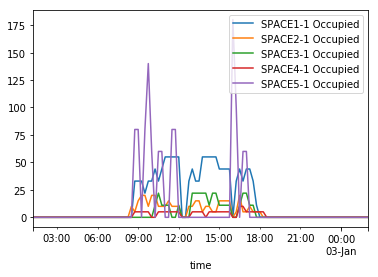

In [21]:
df[100:200][[
    'SPACE1-1 Occupied', 
    'SPACE2-1 Occupied', 
    'SPACE3-1 Occupied', 
    'SPACE4-1 Occupied', 
    'SPACE5-1 Occupied'
]].plot()

In [9]:
df1[100:200][[
    'SPACE1-1 Occupied', 
    'SPACE2-1 Occupied', 
    'SPACE3-1 Occupied', 
    'SPACE4-1 Occupied', 
    'SPACE5-1 Occupied'
]].plot()

KeyError: "None of [Index(['SPACE1-1 Occupied', 'SPACE2-1 Occupied', 'SPACE3-1 Occupied',\n       'SPACE4-1 Occupied', 'SPACE5-1 Occupied'],\n      dtype='object')] are in the [columns]"

In [24]:
df1.equals(df)

True

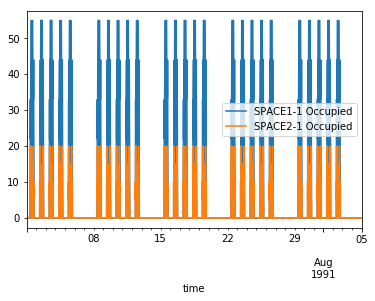

In [11]:
df[['SPACE1-1 Occupied', 'SPACE2-1 Occupied']].plot()

In [ ]:
print('hellow world')

In [13]:
df.to_csv('SAT_SP_heating_blindsNone_daylightingFalse.csv')

In [56]:
# run('heating', False, False)
%time df = run('heating', True, True)
# run('heating', True, False)
# run('heating', True, True)

# run('cooling', False, False)
# run('cooling', False, True)
# run('cooling', True, False)
# run('cooling', True, True)

TypeError: run() missing 2 required positional arguments: 'stpt' and 'co'

In [57]:
# run('heating', False, False)
%time df = run('cooling', None, True, 0, False)
# run('heating', True, False)
# run('heating', True, True)

# run('cooling', False, False)
# run('cooling', False, True)
# run('cooling', True, False)
# run('cooling', True, True)

this node -PROGRAMCONTROL-is not present in base dictionary
running SAT_SP_cooling_blindsNone_setpoint0_daylightingTrue.csv


f:\python\lib\site-packages\pandas\core\arrays\datetimes.py:691: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


Wall time: 24.3 s


In [58]:
data = df['1991-07-01 00:15:00':'1991-08-02 00:00:00']

In [59]:
data['Lights'] = (data['Lights Zone 1'] + data['Lights Zone 2'] +  data['Lights Zone 3'] +  data['Lights Zone 4'])
data['HVAC Power'].sum() + data['Lights'].sum()

<ipython-input-59-f213f3754ceb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lights'] = (data['Lights Zone 1'] + data['Lights Zone 2'] +  data['Lights Zone 3'] +  data['Lights Zone 4'])


8216851.8970755935

In [75]:
df2 = pd.read_csv("gaby_baseline_new/SAT_SP_cooling_blindsNone_setpoint0_daylightingTrue.csv", index_col="time")
data = df2['1991-07-01 00:15:00':'1991-08-02 00:00:00']
data['Lights'] = (data['Lights Zone 1'] + data['Lights Zone 2'] +  data['Lights Zone 3'] +  data['Lights Zone 4'])
data['HVAC Power'].sum() + data['Lights'].sum()

<ipython-input-75-659895243194>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lights'] = (data['Lights Zone 1'] + data['Lights Zone 2'] +  data['Lights Zone 3'] +  data['Lights Zone 4'])


8249459.856937554

In [76]:
df1.columns

Index(['Outdoor Temp.', 'Diff. Solar Rad.', 'Direct Solar Rad.', 'HVAC Power',
       'Sys Out Temp.', 'Heat Coil Power', 'Cool Coil Power', 'MA Temp.',
       'In Node Temp Zone 1', 'In Node Temp Zone 2', 'In Node Temp Zone 3',
       'In Node Temp Zone 4', 'In Node Temp Zone 5', 'In Node Flow Zone 1',
       'In Node Flow Zone 2', 'In Node Flow Zone 3', 'In Node Flow Zone 4',
       'In Node Flow Zone 5', 'PPD Zone 1', 'PPD Zone 2', 'PPD Zone 3',
       'PPD Zone 4', 'PPD Zone 5', 'PMV Zone 1', 'PMV Zone 2', 'PMV Zone 3',
       'PMV Zone 4', 'PMV Zone 5', 'Occu Zone 1', 'Occu Zone 2', 'Occu Zone 3',
       'Occu Zone 4', 'Occu Zone 5', 'Cooling Power Zone 1',
       'Cooling Power Zone 2', 'Cooling Power Zone 3', 'Cooling Power Zone 4',
       'Cooling Power Zone 5', 'Heating Power Zone 1', 'Heating Power Zone 2',
       'Heating Power Zone 3', 'Heating Power Zone 4', 'Heating Power Zone 5',
       'Fan Power', 'Space 1-1 VAV Damper Position',
       'Space 2-1 VAV Damper Position',

<AxesSubplot:xlabel='time'>

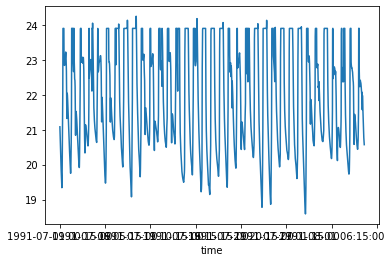

In [78]:
df2['Temp Zone 1'].plot()

In [13]:
ep_model.get_configuration('SCHEDULE:COMPACT', 'DaylightingAvail')


Schedule:Compact,
    DaylightingAvail,         !- Name
    Fraction,                 !- Schedule Type Limits Name
    Through: 12/31,           !- Field 1
    For: AllDays,             !- Field 2
    Until: 24:00,             !- Field 3
    1;                        !- Field 4

In [ ]:
ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'DaylightingAvail'}, {
    'Field 4': dlight
})